In [ ]:
# let's install the packages we need first
%%capture
!pip install openai langchain-openai langchain-community langchain-core

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import os

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set OpenAI API Key for today
os.environ["OPENAI_API_KEY"] = ***insert open ai API key here ***

**LangChain** is a framework designed to build applications powered by large language models (LLMs). One of its core components is the *Chain*, which represents a structured sequence of operations where inputs are processed through a series of steps to generate meaningful outputs.

**What is a Chain?**

A *Chain* in LangChain is a modular pipeline that takes an input (e.g., a user query), processes it through different components (such as prompt templates, LLM calls, or memory storage), and produces an output. This structure allows for flexibility, composability, and control when interacting with LLMs.

First you define a Prompt template. This is a generic mechanism to have a Prompt with variables, like the one you used in the previous practical to import a document. In this simple example we define the Prompt in the function itself rather than through a f""" syntax. If you want to do it through a f""" syntax:

`template = f""" this is a question about {var} """`

 you need to instantiate the variables {vars} before activating the template cell, and then call the function in this way:

`prompt = PromptTemplate.from_template(template)`

In [ ]:
# Define a prompt template with a variable
prompt = PromptTemplate.from_template("What is the capital of {country}?")

Then you define the LLM parameter for the Chain by choosing the model. ChatOpenAI is a LanghChain function.

In [ ]:
# Load an LLM (e.g., OpenAI's GPT-4)
llm = ChatOpenAI(model="gpt-4o-mini")

Nex you create the `chain` using the LangChain function `LLMChain`. Note that in future versions this will be deprecated but this one is the simplest one for a quick intriduction to the concept.

In [ ]:
# Create the chain
chain = LLMChain(llm=llm, prompt=prompt)

Finally, you 'run' the chain. You only need to input the variable which was in the Prompt.

In [ ]:
# Run the chain
response = chain.invoke({"country": "Italy"})
print(response)

{'country': 'Italy', 'text': 'The capital of Italy is Rome.'}


# Prompt Routing

One way to deal with complex queries is to defi**N**e specialised Prompts. If you want to write a generic Prompt covering all topics the prompt might get lengthy and complex but the precision of responses might also vary. By directing prompts to models specialized in a given domain (e.g., legal, medical, technical), responses become more precise and contextually appropriate. You can also define styles for responding depending on the query.

In [ ]:
from langchain.chains.router.multi_prompt import MultiPromptChain
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Here you define templates for all separate prompts you need. You also need to define a generic Prompt template when none of the specialised ones get recognised.

In [ ]:
prompt_1_template = """
You are an expert programmer. Generate concise but readable code. \
Unless otherwise specified, you should only answer in Python. \
Produce code as requested:

{input}
"""

prompt_2_template = """
You are an expert on digital marketing.
You will answer in rhymes:
{input}
"""

# Default prompt template (this could be something like a general FAQ)
default_prompt_template = """
Please provide a general answer to the following query:

{input}
"""

You then define Prompt information that will be used for Prompt selection. Here the query will be matched to the Prompt's "name" field as the main topic.

In [ ]:
prompt_infos = [
    {
        "name": "programming",
        "description": "prompt for code generation",
        "prompt_template": prompt_1_template,
    },
    {
        "name": "marketing",
        "description": "prompt for marketing advice",
        "prompt_template": prompt_2_template,
    },
]

# Add default prompt as a fallback option
default_prompt_info = {
    "name": "default",
    "description": "default general prompt",
    "prompt_template": default_prompt_template,
}

Then, first select the relevant Prompt (you get the default Prompt if none can be matched to the query). The **chain** is created with another LangChain function, which is `MultiPromptChain.from_prompts`

In [ ]:
# Define a default prompt
default_prompt = PromptTemplate.from_template(default_prompt_template)
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [ ]:
# Create the MultiPromptChain with a default chain
chain = MultiPromptChain.from_prompts(llm, prompt_infos, default_chain=default_chain)

Choose ONE of the queries below. Then you can write your own and experiment. You can also modify the similarity threshold for embeddings-based semantic similarity in the code.

In [ ]:
query = "How do I code a dictionary  search?"

In [ ]:
query = "How do I develop an inbound strategy for my new product?"

In [ ]:
query = "What is the capital of South Africa?"

You can run the chain with the query as input. NOTE: there are different ways to run a LangChain chain (`.run` , `.invoke`)

In [ ]:
# You can now pass the query to the chain and get the response
response = chain.run(input=query)
print(response)

To craft your inbound marketing with flair,  
Start with a strategy, make sure you care.  
First define your buyer, know them well,  
Create personas, their needs you must tell.  

Next, produce content—blogs, video, or guides,  
That answers their questions and helps them decide.  
Optimize for search, let keywords be your friend,  
With SEO tactics, your reach will extend.  

Engage on social, be vibrant and bright,  
Share posts that resonate, bring delight.  
Email campaigns should nurture the lead,  
Personalized messages plant the right seed.  

Track all your metrics, see what aligns,  
Refine your approach as your data shines.  
With patience and care, as you steadily grow,  
Your inbound strategy will steal the show!


# LangGraph Version (actual LangChain tutorial, modified for Prompts)

In [ ]:
%%capture
!pip install -qU langgraph

In [ ]:
from operator import itemgetter
from typing import Literal

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict

llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
# Define the prompts we will route to
prompt_1 = ChatPromptTemplate.from_messages(
    [
        ("system", """You are an expert programmer. Generate concise but readable code. \
         Unless otherwise specified, you should only answer in Javascript. \
         Produce code as requested:"""),
        ("human", "{input}"),
    ]
)
prompt_2 = ChatPromptTemplate.from_messages(
    [
        ("system", """You are an expert on marketing. \
         You will answer in rhymes:"""),
        ("human", "{input}"),
    ]
)

In [ ]:
# Construct the chains we will route to. These format the input query
# into the respective prompt, run it through a chat model, and cast
# the result to a string.
chain_1 = prompt_1 | llm | StrOutputParser()
chain_2 = prompt_2 | llm | StrOutputParser()

In [ ]:
# Next: define the chain that selects which branch to route to.
# Here we will take advantage of tool-calling features to force
# the output to select one of two desired branches.
route_system = "Route the user's query to either prompt."
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", route_system),
        ("human", "{input}"),
    ]
)

In [ ]:
# Define schema for output:
class RouteQuery(TypedDict):
    """Route query to destination expert."""

    destination: Literal["programming", "marketing"]


route_chain = route_prompt | llm.with_structured_output(RouteQuery)

In [ ]:
# For LangGraph, we will define the state of the graph to hold the query,
# destination, and final answer.
class State(TypedDict):
    query: str
    destination: RouteQuery
    answer: str


# We define functions for each node, including routing the query:
async def route_query(state: State, config: RunnableConfig):
    destination = await route_chain.ainvoke(state["query"], config)
    return {"destination": destination}


# And one node for each prompt
async def prompt_1(state: State, config: RunnableConfig):
    return {"answer": await chain_1.ainvoke(state["query"], config)}


async def prompt_2(state: State, config: RunnableConfig):
    return {"answer": await chain_2.ainvoke(state["query"], config)}


# We then define logic that selects the prompt based on the classification
def select_node(state: State) -> Literal["prompt_1", "prompt_2"]:
    if state["destination"] == "animal":
        return "prompt_1"
    else:
        return "prompt_2"

This essentially builds a graph that handles the routing of the query to a particular chain in LangChain.

In [ ]:
# Finally, assemble the multi-prompt chain. This is a sequence of two steps:
# 1) Select "animal" or "vegetable" via the route_chain, and collect the answer
# alongside the input query.
# 2) Route the input query to chain_1 or chain_2, based on the
# selection.
graph = StateGraph(State)
graph.add_node("route_query", route_query)
graph.add_node("prompt_1", prompt_1)
graph.add_node("prompt_2", prompt_2)

graph.add_edge(START, "route_query")
graph.add_conditional_edges("route_query", select_node)
graph.add_edge("prompt_1", END)
graph.add_edge("prompt_2", END)
app = graph.compile()

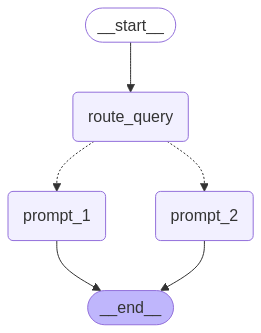

In [ ]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

You can try the previous queries below

In [ ]:
state = await app.ainvoke({"query": "Can you develop a python class that creates a directed graph out of a comma separated string input"})
print(state["destination"])
print(state["answer"])

{'destination': 'programming'}
In Python, let’s make a class so fine,  
To craft a directed graph, it will surely shine.  
With a string of data, comma-separated,  
We'll store the edges, all nicely fated.  

```python
class DirectedGraph:
    def __init__(self, data_string):
        self.graph = {}
        # Split the string by commas, remove spaces too,  
        edges = [pair.strip() for pair in data_string.split(',')]
        for edge in edges:
            if edge:  # Ensure it’s not an empty string
                start, end = edge.split('->')  # Finding the arrow in between
                if start not in self.graph:
                    self.graph[start] = []
                self.graph[start].append(end.strip())

    def display(self):
        for key, value in self.graph.items():
            print(f"{key} -> {', '.join(value)}")

# Example usage:
data = "A->B, A->C, B->D, C->D"
graph = DirectedGraph(data)
graph.display() 
```

In this code, we guide the flow,  
From start to end

In the [LangSmith trace](https://smith.langchain.com/public/1017a9d2-2d2a-4954-a5fd-5689632b4c5f/r) we can see the tool call that routed the query and the prompt that was selected to generate the answer.

</details>

## Overview:

- Under the hood, `MultiPromptChain` routed the query by instructing the LLM to generate JSON-formatted text, and parses out the intended destination. It took a registry of string prompt templates as input.
- The LangGraph implementation, implemented above via lower-level primitives, uses tool-calling to route to arbitrary chains. In this example, the chains include chat model templates and chat models.